# Imports

In [1]:
import pandas as pd
import numpy as np
import math
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import array, linspace
from sklearn.neighbors import KernelDensity
from matplotlib.pyplot import plot
from scipy.signal import argrelextrema
import random

# pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (60, 40)
%matplotlib inline

In [2]:
import torch
import torch.nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import math
from sklearn.metrics import r2_score
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [3]:
from handlers.DataHandler import DataHandler
from handlers.ClusterHandler import ClusterHandler
import handlers.GAHandler as GAHandler

In [4]:
### GLOBAL VARIABLES ###
y_horizon = 13

# Load Data

In [5]:
top100 = ['AAPL', 'MSFT', 'NVDA', 'AMZN', 'META', 'GOOGL', 'BRK', 'GOOG',
       'LLY', 'JPM', 'AVGO', 'TSLA', 'UNH', 'XOM', 'V', 'PG', 'JNJ', 'MA',
       'COST', 'HD', 'ABBV', 'WMT', 'MRK', 'NFLX', 'KO', 'BAC', 'ADBE',
       'PEP', 'CVX', 'CRM', 'TMO', 'ORCL', 'LIN', 'AMD', 'ACN', 'MCD',
       'ABT', 'CSCO', 'PM', 'WFC', 'IBM', 'TXN', 'QCOM', 'GE', 'DHR',
       'VZ', 'INTU', 'AMGN', 'NOW', 'ISRG', 'NEE', 'SPGI', 'PFE', 'CAT',
       'DIS', 'RTX', 'CMCSA', 'GS', 'UNP', 'T', 'AMAT', 'PGR',
       'LOW', 'AXP', 'TJX', 'HON', 'BKNG', 'ELV', 'COP', 'SYK', 'MS',
       'LMT', 'VRTX', 'BLK', 'REGN', 'MDT', 'BSX', 'PLD', 'CB', 'ETN',
       'C', 'MMC', 'ADP', 'AMT', 'PANW', 'ADI', 'SBUX', 'MDLZ', 'CI',
       'TMUS', 'FI', 'BMY', 'DE', 'GILD', 'BX', 'NKE', 'SO', 'LRCX', 'MU', 'KLAC']

top10 = top100[:10]

In [6]:
# train_X, train_y, test_X, test_y = DataHandler.getTickers(top100, "1998-01-01", "2015-12-31", "2016-01-01", "2024-01-01", y_horizon)
train_X, train_y, test_X, test_y = DataHandler.getTickers(top10, "1998-01-01", "2015-12-31", "2016-01-01", "2024-01-01", y_horizon)
# train_X, train_y, test_X, test_y = DataHandler.getData("MS", "1998-01-01", "2015-12-31", "2016-01-01", "2023-01-01", y_horizon)

train_X.drop(columns=['symbol'], inplace=True)
train_y.drop(columns=['symbol'], inplace=True)
test_X.drop(columns=['symbol'], inplace=True)
test_y.drop(columns=['symbol'], inplace=True)

# train_X.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
# test_X.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)

# Create and use the Cluster object
cls = ClusterHandler(train_X.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume']), train_y, 
                     test_X.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume']), test_y, 
                     eps=0.00001, mergeCluster=True, splitLargest=True)
clustered_train_X, clustered_train_y, clustered_test_X, clustered_test_y = cls.cluster()

# Access the clustering results
feature_cluster_stats = cls.feature_cluster_stats
y_cluster_stats = cls.y_cluster_stats

2024-09-19 00:22:22,853 - handlers.DataHandler - INFO - Loading data for AAPL from cache
2024-09-19 00:22:22,994 - handlers.DataHandler - INFO - Loading data for MSFT from cache
2024-09-19 00:22:23,124 - handlers.DataHandler - INFO - Loading data for NVDA from cache
2024-09-19 00:22:23,254 - handlers.DataHandler - INFO - Loading data for AMZN from cache
2024-09-19 00:22:23,387 - handlers.DataHandler - INFO - Loading data for META from cache
2024-09-19 00:22:23,507 - handlers.DataHandler - INFO - Loading data for GOOGL from cache
2024-09-19 00:22:23,634 - handlers.DataHandler - INFO - Loading data for BRK from cache
2024-09-19 00:22:23,757 - handlers.DataHandler - INFO - Loading data for GOOG from cache
2024-09-19 00:22:23,887 - handlers.DataHandler - INFO - Loading data for LLY from cache
2024-09-19 00:22:24,018 - handlers.DataHandler - INFO - Loading data for JPM from cache
daily_log_return_0 had 9 clusters
daily_log_return_1 had 9 clusters
daily_log_return_2 had 9 clusters
daily_log_

In [59]:
clustered_train_X.drop(columns=clustered_train_X.columns[clustered_train_X.isna().any(axis=0)], inplace=True)
clustered_test_X.drop(columns=clustered_test_X.columns[clustered_test_X.isna().any(axis=0)], inplace=True)

In [7]:
clustered_train_X.isna().any().any()

np.False_

In [8]:
clustered_test_X.isna().any().any()

np.False_

In [9]:
(clustered_test_X.columns == clustered_train_X.columns).all()

np.True_

# Functions and model definition

In [10]:
class TransformerModel(torch.nn.Module):
    def __init__(self, input_dim, output_dim, num_heads=10, ff_dim=32, num_transformer_blocks=4, mlp_units=256, dropout=0.25, noHiddenLayers=1, sigmoidOrSoftmax=0):
        super(TransformerModel, self).__init__()

        # print(f"Initializing TransformerModel with input_dim: {input_dim}, output_dim: {output_dim}")

        # # Ensure input_dim is divisible by num_heads
        # if input_dim % num_heads != 0:
        #     new_input_dim = (input_dim // num_heads + 1) * num_heads
        #     print(f"Adjusting input_dim from {input_dim} to {new_input_dim} to be divisible by num_heads ({num_heads})")
        #     input_dim = new_input_dim

        # Encoder layer with ff_dim and dropout
        encoder_layers = TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            activation='relu',
            batch_first=True
        )
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=num_transformer_blocks)
        
        # Dropout layer
        self.dropout = torch.nn.Dropout(dropout)
        
        # MLP layers
        fcList = [torch.nn.Linear(input_dim, mlp_units), torch.nn.ReLU(), self.dropout]
        for i in range(noHiddenLayers):
            fcList.extend([
                torch.nn.Linear(mlp_units, mlp_units//2),
                torch.nn.ReLU(),
                self.dropout
            ])
            mlp_units = mlp_units//2
        fcList.append(torch.nn.Linear(mlp_units, output_dim))
        
        # Output activation
        if sigmoidOrSoftmax == 0:
            fcList.append(torch.nn.Sigmoid())
        else:
            fcList.append(torch.nn.Softmax(dim=-1))
        
        self.fc = torch.nn.Sequential(*fcList)

    def forward(self, src):
        # src shape: (batch_size, seq_length, input_dim)
        
        # Pass input through the transformer encoder
        encoder_output = self.transformer_encoder(src)
        
        # Apply dropout after the transformer encoder
        encoder_output = self.dropout(encoder_output)
        
        # Pass through the MLP layers
        output = self.fc(encoder_output)
        return output
    
def increaseInstancesExtreme(train, thresholdToIncrease=0.03):
    extraData = train[(train[f"Close_t+{yTarget}"]>thresholdToIncrease) | (train[f"Close_t+{yTarget}"]<-thresholdToIncrease)]
    return pd.concat([train, extraData] ,axis = 0)

def padData(X, X_test, padDim):
    zeros_array = np.zeros((X.shape[0], padDim))
    zeros_array_test = np.zeros((X_test.shape[0], padDim))

    X = np.concatenate((X, zeros_array), axis=1)
    X_test = np.concatenate((X_test, zeros_array_test), axis=1)
    return X, X_test

def testData(pred, Y_test):
    res = (pred-Y_test)**2
    res[np.isnan(res)]=0
    mse = np.mean(res)
    return mse  

# Genetic Algorithm

In [12]:
def hyperparameters():
    parameters = {
        'num_heads': [1, 2, 3, 4],
        'feed_forward_dim': [32, 64, 128],
        'num_transformer_blocks': [1, 2, 3],
        'mlp_units': [64, 128, 256, 512],
        'dropout_rate': [0, 0.05, 0.1, 0.2],
        'learning_rate': [0.001, 0.0001, 0.00001, 0.000005],
        'num_mlp_layers': [3, 5, 8],
        'num_epochs': [50, 100, 200, 500],
        'activation_function': [0, 1],  # 0 for sigmoid, 1 for softmax
        'batch_size': [128, 256, 512, 1024, 2048]
    }
    return parameters

def generate_population(size):
    parameters = hyperparameters()
    population = []
    
    while len(population) < size:
        chromosome = {key: random.choice(value) for key, value in parameters.items()}
        if chromosome not in population:
            population.append(chromosome)
    return population

def crossover(parent1, parent2):
    child = {}
    for key in parent1.keys():
        child[key] = random.choice([parent1[key], parent2[key]])
    return child

def mutation(chromosome, mutation_rate=0.1):
    parameters = hyperparameters()
    for key in chromosome.keys():
        if random.random() < mutation_rate:
            chromosome[key] = random.choice(parameters[key])
    return chromosome

def fitness(chromosome, X, y, t_X, t_y, crisp_t_y):
    model, r2, pred = train_ga_model(
        X, y, t_X, t_y, crisp_t_y,
        num_heads=chromosome['num_heads'],
        feed_forward_dim=chromosome['feed_forward_dim'],
        num_transformer_blocks=chromosome['num_transformer_blocks'],
        mlp_units=chromosome['mlp_units'],
        dropout_rate=chromosome['dropout_rate'],
        learning_rate=chromosome['learning_rate'],
        num_mlp_layers=chromosome['num_mlp_layers'],
        num_epochs=chromosome['num_epochs'],
        activation_function=chromosome['activation_function'],
        batch_size=chromosome['batch_size']
    )
    return r2

def genetic_algorithm(X, y, t_X, t_y, crisp_t_y, population_size=20, generations=10, elite_size=2):
    population = generate_population(population_size)
    
    for generation in range(generations):
        print(f"Generation {generation + 1}/{generations}")
        
        # Evaluate fitness
        fitness_scores = [(chromosome, fitness(chromosome, X, y, t_X, t_y, crisp_t_y)) for chromosome in population]
        fitness_scores.sort(key=lambda x: x[1], reverse=True)
        
        # Select elite
        new_population = [chromosome for chromosome, _ in fitness_scores[:elite_size]]
        
        # Generate offspring
        while len(new_population) < population_size:
            parent1, parent2 = random.sample(population, 2)
            child = crossover(parent1, parent2)
            child = mutation(child)
            new_population.append(child)
        
        population = new_population
        
        best_chromosome, best_fitness = fitness_scores[0]
        print(f"Best fitness: {best_fitness}")
        print(f"Best chromosome: {best_chromosome}")
    
    return fitness_scores[0]

# GA Train

In [14]:
pred_col = test_y.columns[0]

train_val_split = 0.7
unique_train_dates = clustered_train_X.index.unique()
split_date = unique_train_dates[int(len(unique_train_dates) * train_val_split)]


X = clustered_train_X.loc[clustered_train_X.index < split_date].to_numpy()
val_X = clustered_train_X.loc[clustered_train_X.index >= split_date].to_numpy()

y = clustered_train_y[[c for c in clustered_train_y.columns if pred_col in c]].loc[clustered_train_y.index < split_date].to_numpy()
val_y = clustered_train_y[[c for c in clustered_train_y.columns if pred_col in c]].loc[clustered_train_y.index >= split_date].to_numpy()
crisp_val_y = train_y[pred_col].loc[train_y.index >= split_date].to_numpy()

In [24]:
best_chromosome, best_fitness = genetic_algorithm(X, y, val_X, val_y, crisp_val_y, population_size=20, generations=10, elite_size=2)
print("Best hyperparameters:", best_chromosome)
print("Best R2 score:", best_fitness)

# Train final model with best hyperparameters
# final_model, final_r2, final_pred = train_ga_model(
#     X, y, t_X, t_y, crisp_t_y,
#     **best_chromosome
# )
# print("Final model R2 score:", final_r2)

Generation 1/10
Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200] | Loss: 0.1688 | R² Score: -1497.9885 | Log Return R² Score: -6.4542
Epoch [51/200] | Loss: 0.0010 | R² Score: -0.0337 | Log Return R² Score: 0.0049
Epoch [101/200] | Loss: 0.0004 | R² Score: 0.1205 | Log Return R² Score: -0.0114


KeyboardInterrupt: 

In [ ]:
print("Best hyperparameters:", best_chromosome)
print("Best R2 score:", best_fitness)

In [ ]:
X, t_X = clustered_train_X.to_numpy(), clustered_test_X.to_numpy()
pred_col = test_y.columns[0]
y = clustered_train_y[[c for c in clustered_train_y.columns if pred_col in c]].to_numpy()
t_y = clustered_test_y[[c for c in clustered_test_y.columns if pred_col in c]].to_numpy()
crisp_t_y = test_y[pred_col].to_numpy()

final_model, final_r2, final_pred = train_ga_model(
    X, y, t_X, t_y, crisp_t_y,
    **best_chromosome
)
print("Final model R2 score:", final_r2)

# Train

In [13]:
def train_ga_model(X, Y, X_test, Y_test, # fuzzified inputs
                   Y_test_raw, # crisp value
                   num_heads, feed_forward_dim, num_transformer_blocks, mlp_units, dropout_rate, 
                   learning_rate, num_mlp_layers, num_epochs, activation_function, batch_size):

    OUTPUT_FREQ = 50
    # Detect GPU availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on {device}")

    # Load and pad data
    x_padded, x_test_padded = padData(X, X_test, math.ceil(X.shape[1] / num_heads) * num_heads - X.shape[1])

    # Initialize the model
    model = TransformerModel(
        input_dim=x_padded.shape[1], 
        output_dim=Y.shape[1],
        num_heads=num_heads, 
        ff_dim=feed_forward_dim, 
        num_transformer_blocks=num_transformer_blocks, 
        mlp_units=mlp_units, 
        dropout=dropout_rate, 
        sigmoidOrSoftmax=activation_function
    ).double()

    # Send model to the detected device
    model = model.to(device)

    # Set loss function and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create DataLoader for training
    assert x_padded.shape[0] == Y.shape[0]
    train_dataset = TensorDataset(torch.from_numpy(x_padded), torch.from_numpy(Y))
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    for epoch in range(num_epochs):
        epoch_loss = 0
        model.train()

        all_preds = []
        all_targets = []

        for inputs, targets in train_dataloader:
            # Move data to the correct device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Collect predictions and targets for R² score computation
            all_preds.append(outputs.detach().cpu().numpy())
            all_targets.append(targets.detach().cpu().numpy())

        # Concatenate all batch predictions and targets
        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)

        if epoch % OUTPUT_FREQ == 0:
            # Compute R² score
            r2 = r2_score(all_targets, all_preds)
            log_return_r2 = eval_model(model, x_test_padded, Y_test, Y_test_raw)
            
            print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss / len(train_dataloader):.4f} | R² Score: {r2:.4f} | Log Return R² Score: {log_return_r2:.4f}')

    # return all_preds, all_targets

    # Evaluate on test data
    test_dataset = TensorDataset(torch.from_numpy(x_test_padded), torch.from_numpy(Y_test))
    test_dataloader = DataLoader(test_dataset, batch_size=512*4, shuffle=False)

    model.eval()
    pred_list = []
    with torch.no_grad():
        for inputs, _ in test_dataloader:
            pred = model(inputs.to(device)).cpu()
            pred_list.append(pred)

    mse = testData(np.concatenate(pred_list), Y_test)
    # print(f'Test Data MSE: {mse:.7f}')

    # Calculate R2 score
    pred = np.concatenate(pred_list)
    pred[np.isnan(pred)] = 0

    pred_log_returns = cls.deFuzzify(pred, pred_col)
    pred_log_returns = np.nan_to_num(pred_log_returns, nan=0, posinf=0, neginf=0)
    
    # pred_closing = addResToClosing(cls, res)[:-yTarget]
    # actual_closing = cls.test.Close[yTarget:].to_numpy()
    # r2_score_value = r2_score(actual_closing, pred_closing)
    
    r2_score_value = r2_score(Y_test_raw, pred_log_returns)
    print("Test R2 Score:", r2_score_value)

    return model, r2_score_value, pred

def eval_model(model, X: np.array, Y: np.array, Y_crisp: np.array):
    """
    X & Y are fuzzified inputs
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # print(f"Using {device}")    

    model = model.to(device)
    model.eval()
    pred_list = []

    test_dataset = TensorDataset(torch.from_numpy(X), torch.from_numpy(Y))
    test_dataloader = DataLoader(test_dataset, batch_size=512*4, shuffle=False)
    
    with torch.no_grad():
        for inputs, _ in test_dataloader:
            pred = model(inputs.to(device)).cpu()
            pred_list.append(pred)

    # mse = testData(np.concatenate(pred_list), Y_test)
    # print(f'Test Data MSE: {mse:.7f}')

    # Calculate R2 score
    pred = np.concatenate(pred_list)
    pred[np.isnan(pred)] = 0

    pred_log_returns = cls.deFuzzify(pred, pred_col)
    pred_log_returns = np.nan_to_num(pred_log_returns, nan=0, posinf=0, neginf=0)
    
    # pred_closing = addResToClosing(cls, res)[:-yTarget]
    # actual_closing = cls.test.Close[yTarget:].to_numpy()
    # r2_score_value = r2_score(actual_closing, pred_closing)
    
    r2_score_value = r2_score(Y_crisp, pred_log_returns)
    # print("Test R2 Score:", r2_score_value)    
    return r2_score_value


In [14]:
X, t_X = clustered_train_X.to_numpy(), clustered_test_X.to_numpy()
pred_col = test_y.columns[0]
y = clustered_train_y[[c for c in clustered_train_y.columns if pred_col in c]].to_numpy()
t_y = clustered_test_y[[c for c in clustered_test_y.columns if pred_col in c]].to_numpy()
crisp_t_y = test_y[pred_col].to_numpy()

model, r2, pred = train_ga_model(
    X, y, t_X, t_y,
    crisp_t_y,
    num_heads=1, 
    feed_forward_dim=1, 
    num_transformer_blocks=3, 
    mlp_units=64, 
    dropout_rate=0.1, 
    learning_rate=5e-06, 
    num_mlp_layers=3, 
    num_epochs=100, 
    activation_function=0,  # 0 for sigmoid, 1 for softmax
    batch_size=128
)

Training on cuda


/home/FYP/chia0427/.conda/envs/fyp1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] | Loss: 0.1733 | R² Score: -791.5465 | Log Return R² Score: -63.6182
Epoch [51/100] | Loss: 0.0029 | R² Score: -1.8431 | Log Return R² Score: -0.6691
Test R2 Score: 0.10057956114428501


In [42]:
pred_log_returns = cls.deFuzzify(pred, pred_col)
pred_log_returns = np.nan_to_num(pred_log_returns, nan=0, posinf=0, neginf=0)

pred_close = add_log_return_to_close(test_X['Close'].to_numpy(), pred_log_returns)
target_close = add_log_return_to_close(test_X['Close'].to_numpy(), test_y[pred_col].to_numpy())
close_r2_score = r2_score(target_close, pred_close)
win_rate = calculate_win_rate(crisp_t_y, pred_log_returns)

print(f"Stock Price R2: {close_r2_score:.4f}")
print(f"Win Rate: {100 * win_rate:.4f}%")

Stock Price R2: 0.9991
Win Rate: 56.1682%


In [39]:
def add_log_return_to_close(close_0: np.array, log_returns: np.array) -> np.array:
    """use log returns to calculate next period close prices close_1"""
    close_1 = close_0 * np.exp(log_returns)
    return close_1

def calculate_win_rate(target_returns: np.array, pred_returns: np.array) -> float:
    target_returns = target_returns > 0
    pred_returns = pred_returns > 0
    return (target_returns == pred_returns).sum() / len(pred_returns)

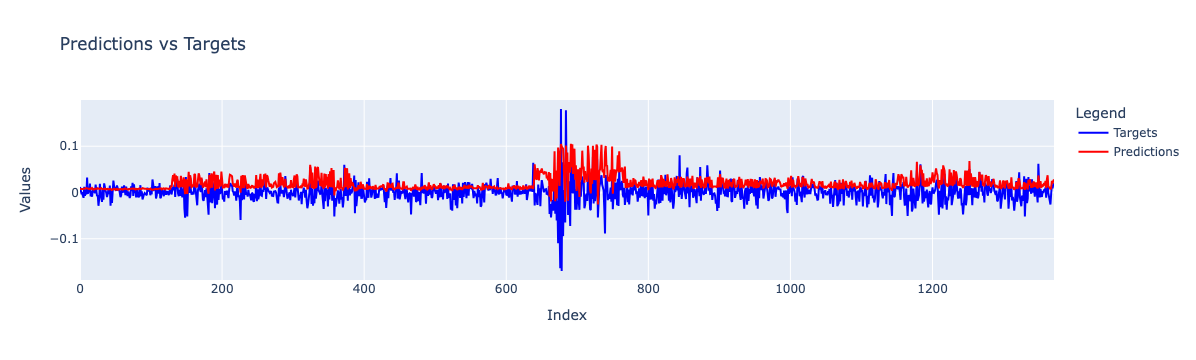

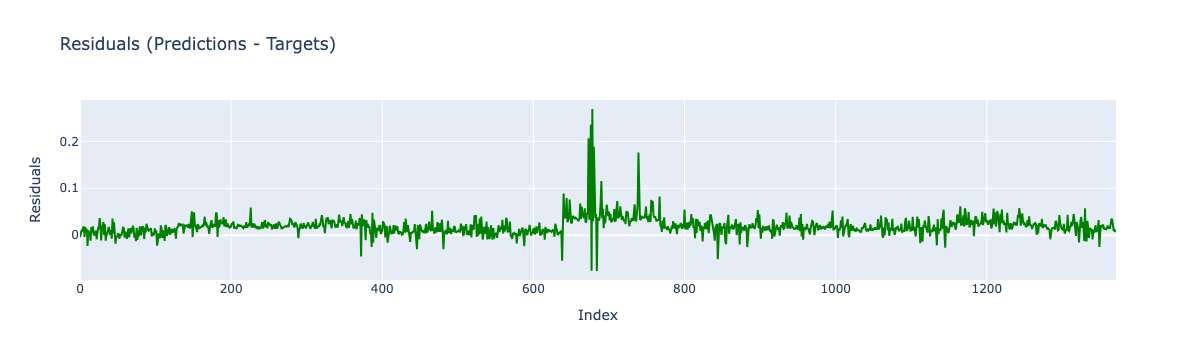

In [80]:
import plotly.graph_objects as go

def visualize_predictions_vs_target(predictions, targets):
    # Calculate residuals (difference between predictions and targets)
    residuals = predictions - targets

    # Create x-axis (index for plotting)
    x = np.arange(len(predictions))

    # Create line plot for predictions and targets
    fig = go.Figure()

    # Plot targets
    fig.add_trace(go.Scatter(x=x, y=targets, mode='lines', name='Targets', line=dict(color='blue')))
    
    # Plot predictions
    fig.add_trace(go.Scatter(x=x, y=predictions, mode='lines', name='Predictions', line=dict(color='red')))

    # Add title and labels
    fig.update_layout(
        title='Predictions vs Targets',
        xaxis_title='Index',
        yaxis_title='Values',
        legend_title='Legend',
        height=600
    )

    # Show plot
    fig.show()

    # Residuals plot (Difference between predictions and targets)
    fig_residuals = go.Figure()

    # Plot residuals
    fig_residuals.add_trace(go.Scatter(x=x, y=residuals, mode='lines', name='Residuals', line=dict(color='green')))

    # Add title and labels for residuals plot
    fig_residuals.update_layout(
        title='Residuals (Predictions - Targets)',
        xaxis_title='Index',
        yaxis_title='Residuals',
        height=600
    )

    # Show residuals plot
    fig_residuals.show()

visualize_predictions_vs_target(deFuzzify(pred, cls.y_cluster_stats[pred_col]), crisp_t_y)


In [37]:
y.shape

(4138, 8)

In [33]:
all_preds.shape

(4138, 8)

In [34]:
all_targets.shape

(4138, 8)

In [43]:
cls.y_cluster_stats['y_log_return_0']

{0: {'mean': np.float64(-0.23928210301371133),
  'std': np.float64(0.05194219801211237)},
 1: {'mean': np.float64(-0.15253550264852994),
  'std': np.float64(0.010413746511490407)},
 2: {'mean': np.float64(-0.10600404812715959),
  'std': np.float64(0.011546869280038686)},
 3: {'mean': np.float64(-0.0519643569928573),
  'std': np.float64(0.014571049995484054)},
 4: {'mean': np.float64(-0.010892969914091829),
  'std': np.float64(0.00970862276492395)},
 5: {'mean': np.float64(0.015303584064657098),
  'std': np.float64(0.009682180479312305)},
 6: {'mean': np.float64(0.05298666916599276),
  'std': np.float64(0.010041857574314186)},
 7: {'mean': np.float64(0.1345724956975827),
  'std': np.float64(0.08643161529008503)}}

In [44]:
[i['mean'] for i in cls.y_cluster_stats['y_log_return_0'].values()]

[np.float64(-0.23928210301371133),
 np.float64(-0.15253550264852994),
 np.float64(-0.10600404812715959),
 np.float64(-0.0519643569928573),
 np.float64(-0.010892969914091829),
 np.float64(0.015303584064657098),
 np.float64(0.05298666916599276),
 np.float64(0.1345724956975827)]

In [50]:
np.squeeze((all_preds * np.tile([i['mean'] for i in cls.y_cluster_stats['y_log_return_0'].values()],(all_preds.shape[0],1))).sum(axis = 1, keepdims= True))

array([0.00957996, 0.00918855, 0.0087886 , ..., 0.00832616, 0.00966396,
       0.00961016])

In [52]:
cls.y_cluster_stats['y_log_return_0']

{0: {'mean': np.float64(-0.23928210301371133),
  'std': np.float64(0.05194219801211237)},
 1: {'mean': np.float64(-0.15253550264852994),
  'std': np.float64(0.010413746511490407)},
 2: {'mean': np.float64(-0.10600404812715959),
  'std': np.float64(0.011546869280038686)},
 3: {'mean': np.float64(-0.0519643569928573),
  'std': np.float64(0.014571049995484054)},
 4: {'mean': np.float64(-0.010892969914091829),
  'std': np.float64(0.00970862276492395)},
 5: {'mean': np.float64(0.015303584064657098),
  'std': np.float64(0.009682180479312305)},
 6: {'mean': np.float64(0.05298666916599276),
  'std': np.float64(0.010041857574314186)},
 7: {'mean': np.float64(0.1345724956975827),
  'std': np.float64(0.08643161529008503)}}

In [12]:
def deFuzzify(pred: np.array, y_cluster_info: dict) -> np.array:
    """
    defuzzification uising weighted average technique
    transform fuzzy memberships -> log returns
    """
    centers = [dic['mean'] for dic in y_cluster_info.values()]
    stds = [dic['std'] for dic in y_cluster_info.values()]

    centers = np.tile(centers, (pred.shape[0], 1))
    pred = np.nan_to_num(pred, nan=0, posinf=0, neginf=0)

    denominator = pred.sum(axis=1, keepdims=True)
    numerator = (pred * centers).sum(axis = 1, keepdims=True)
    result = numerator / denominator
    result = np.squeeze(result)

    return result
    

In [59]:
deFuzzify(all_preds, cls.y_cluster_stats['y_log_return_0']).shape

(4138,)

In [75]:
from sklearn.metrics import r2_score

r2_score(train_X['Close'].iloc[13:], train_X['Close'].shift(13).iloc[13:])

0.935833218015573

In [67]:
train

NameError: name 'train' is not defined

In [70]:
train_X['Close']

Date
1999-07-06    25.664207
1999-07-07    25.695587
1999-07-08    25.774012
1999-07-09    25.993652
1999-07-12    25.601460
                ...    
2015-12-07    27.070307
2015-12-08    26.586359
2015-12-09    26.047758
2015-12-10    26.086788
2015-12-11    25.040825
Name: Close, Length: 4138, dtype: float64

In [72]:
train_X['Close'].shift(1)

Date
1999-07-06          NaN
1999-07-07    25.664207
1999-07-08    25.695587
1999-07-09    25.774012
1999-07-12    25.993652
                ...    
2015-12-07    27.569885
2015-12-08    27.070307
2015-12-09    26.586359
2015-12-10    26.047758
2015-12-11    26.086788
Name: Close, Length: 4138, dtype: float64